--- Molecular Sampling and Analysis Program ---
Configuration:
  - Number of Sites: 3
  - Number of Functional Groups: 7
  - Symmetry: {1, 3} & {2}
🧬 Generating all possible molecular combinations...
✨ Generation complete! Found 196 unique molecules.

💾 Saving results to all_possible_molecules.xlsx...
✅ File saved successfully: all_possible_molecules.xlsx

Sampling Target: Select 39 representative molecules from a total of 196.

💡 Performing hybrid sampling...

🔬 Classifying all molecules by canonical pattern...
📊 Classification complete. Statistics for each pattern:
  - Pattern ABC: 105 molecules
  - Pattern AAB: 42 molecules
  - Pattern ABA: 42 molecules
  - Pattern AAA: 7 molecules

💾 Saving results to representative_sample.xlsx...
✅ File saved successfully: representative_sample.xlsx

✔️ Sampling complete! The final sample size is: 39

📈 Generating UMAP visualization...


D:\anaconda\envs\matsci-ai\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\anaconda\envs\matsci-ai\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP visualization generated. It will be displayed in a new window.


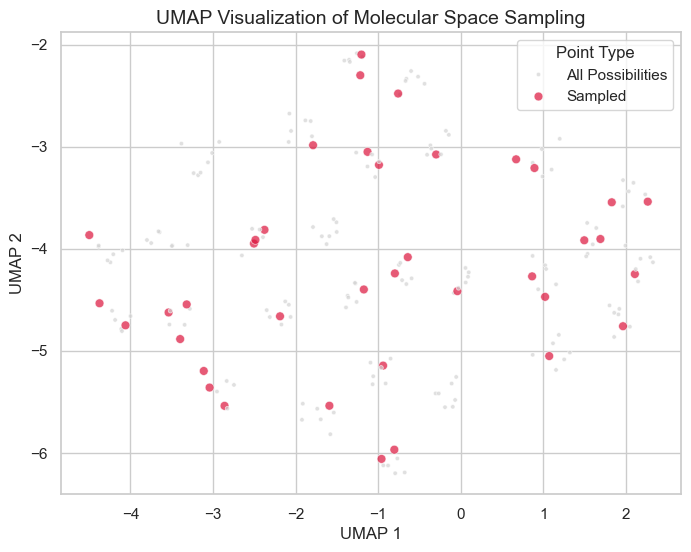


--- Program execution finished. ---


In [3]:
# Molecule Generation & Sampling
"""
Molecule Combination Generation and Representative Sampling Script

This script is designed for generating and selecting from molecular libraries
in combinatorial chemistry or materials science.
Key features include:
1. Generating all unique molecular combinations based on a given number of sites,
   types of functional groups, and symmetry rules.
2. Classifying the complete molecular library to identify different
   structural configurations (patterns).
3. Executing an advanced hybrid sampling strategy to obtain a manageable and
   highly representative subset of the library. This strategy ensures
   reproducibility and diversity by randomly selecting from equally optimal
   solutions while strictly aiming for component balance.
4. Providing UMAP dimensionality reduction for intuitive visualization and
   assessment of the sampling coverage and uniformity.
"""

import itertools
import random
import math
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import OneHotEncoder

# ==============================================================================
# 1. User Configuration
# ==============================================================================
# Please modify the parameters in this section to suit your experimental needs.

# --- Molecular Structure Parameters ---
# Total number of substitutable sites on the molecular scaffold.
# Example: For a molecular core with 4 attachment points, set this to 4.
NUM_SITES = 3

# The total number of different functional groups (or building blocks) available.
# The program will internally number them as 1, 2, ...
# Example: If you have a library of 8 different amines, set this to 8.
NUM_FUNCTIONAL_GROUPS = 7

# --- Symmetry Definition ---
# Defines the symmetry of the sites to identify and remove duplicate molecules. Site numbering starts from 1.
# - No symmetry: "" (leave as an empty string)
# - Sites 1 and 3 are equivalent: "1,3"
# - Sites 1 and 4 are equivalent, AND sites 2 and 3 are equivalent: "1,4; 2,3" (use a semicolon to separate groups)
# - Sites 1, 2, and 3 are mutually equivalent: "1,2,3"
# - Sites 1 through 4 are mutually equivalent (continuous range): "1-4"
SYMMETRY_STRING = "1,3"

# --- Sampling Strategy Parameters ---
# The fraction of unique molecules to be sampled (a value between 0.0 and 1.0).
# Example: 0.1 means selecting 10% of the molecules from the total library.
SAMPLE_FRACTION = 0.2

# --- Reproducibility Control ---
# Controls the reproducibility of random processes (like sampling and visualization) to ensure consistent results.
# - Set to an integer (e.g., 0, 42) to guarantee identical results on every run.
# - Set to None to produce new random results on each run.
RANDOM_SEED = 0


# ==============================================================================
# 2. Core Logic
# ==============================================================================
# It is generally not necessary to modify the code below.

def parse_symmetry_string(symmetry_str: str, num_sites: int) -> list[tuple[int, ...]]:
    """Parses a human-readable symmetry string into a program-usable format."""
    if not symmetry_str.strip():
        return [tuple([i]) for i in range(num_sites)]
    all_sites = set(range(num_sites))
    processed_sites = set()
    symmetry_groups = []
    group_definitions = symmetry_str.split(';')
    for group_def in group_definitions:
        group_def = group_def.strip()
        if not group_def: continue
        current_group = set()
        parts = group_def.split(',')
        for part in parts:
            part = part.strip()
            if not part: continue
            if '-' in part:
                try:
                    start, end = map(int, part.split('-'))
                    for i in range(start, end + 1): current_group.add(i - 1)
                except ValueError: pass
            elif part.isdigit():
                current_group.add(int(part) - 1)
        if current_group:
            sorted_group = tuple(sorted(list(current_group)))
            symmetry_groups.append(sorted_group)
            processed_sites.update(current_group)
    unprocessed_sites = all_sites - processed_sites
    for site in sorted(list(unprocessed_sites)):
        symmetry_groups.append(tuple([site]))
    return sorted(symmetry_groups)

def get_canonical_form(molecule: tuple, symmetry_map: list[tuple[int, ...]]) -> tuple:
    """Calculates the canonical form of a molecule based on symmetry for deduplication."""
    min_molecule = molecule
    original_indices_flat = list(itertools.chain(*symmetry_map))
    group_permutations = [list(itertools.permutations(group)) for group in symmetry_map]

    for index_combo in itertools.product(*group_permutations):
        remap = {orig: new for orig, new in zip(original_indices_flat, itertools.chain(*index_combo))}
        current_permutation = tuple(molecule[remap[i]] for i in range(len(molecule)))
        if current_permutation < min_molecule:
            min_molecule = current_permutation
    return min_molecule

def generate_unique_molecules(num_sites: int, num_groups: int, symmetry_map: list) -> list[tuple]:
    """Generates all unique molecules, taking symmetry into account."""
    print("🧬 Generating all possible molecular combinations...")
    unique_molecules = set()
    all_combinations = itertools.product(range(1, num_groups + 1), repeat=num_sites)
    for mol in all_combinations:
        unique_molecules.add(get_canonical_form(mol, symmetry_map))
    print(f"✨ Generation complete! Found {len(unique_molecules)} unique molecules.")
    return sorted(list(unique_molecules))

def get_canonical_pattern(molecule: tuple, symmetry_map: list[tuple[int, ...]]) -> str:
    """Calculates the canonical structural pattern of a molecule, handling positional isomers and normalizing the pattern itself."""
    initial_pattern = ""
    group_to_symbol = {}
    symbols = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    next_symbol_idx = 0
    for group_id in molecule:
        if group_id not in group_to_symbol:
            group_to_symbol[group_id] = symbols[next_symbol_idx]
            next_symbol_idx += 1
        initial_pattern += group_to_symbol[group_id]
    
    min_pattern = initial_pattern
    site_permutations = []
    original_indices_flat = list(itertools.chain(*symmetry_map))
    group_permutations = [list(itertools.permutations(group)) for group in symmetry_map]
    for index_combo in itertools.product(*group_permutations):
        remap = {orig: new for orig, new in zip(original_indices_flat, itertools.chain(*index_combo))}
        site_permutations.append(remap)

    unique_chars = sorted(list(set(initial_pattern)))
    char_relabelings = list(itertools.permutations(unique_chars))

    for site_perm_map in site_permutations:
        permuted_pattern = "".join(initial_pattern[site_perm_map[i]] for i in range(len(initial_pattern)))
        for relabeling in char_relabelings:
            relabel_map = {orig: new for orig, new in zip(unique_chars, relabeling)}
            final_candidate = "".join(relabel_map[char] for char in permuted_pattern)
            if final_candidate < min_pattern:
                min_pattern = final_candidate
    return min_pattern

def categorize_molecules(molecules: list[tuple], symmetry_map: list[tuple[int, ...]]) -> dict:
    """Categorizes molecules based on their canonical structural patterns."""
    print("\n🔬 Classifying all molecules by canonical pattern...")
    categorized = {}
    for mol in molecules:
        pattern = get_canonical_pattern(mol, symmetry_map)
        if pattern not in categorized:
            categorized[pattern] = []
        categorized[pattern].append(mol)

    print("📊 Classification complete. Statistics for each pattern:")
    for pattern, mol_list in sorted(categorized.items(), key=lambda item: len(item[1]), reverse=True):
        print(f"  - Pattern {pattern}: {len(mol_list)} molecules")
    return categorized

def perform_hybrid_sampling(all_molecules: list, sample_fraction: float, symmetry_map: list) -> list[tuple]:
    """
    Performs a hybrid sampling strategy.
    
    This method strictly pursues component balance and randomly selects from
    equally optimal candidates (i.e., those with the same lowest cost) to ensure
    both diversity and reproducibility.
    """
    if not all_molecules:
        return []

    print("\n💡 Performing hybrid sampling...")
    categorized_molecules = categorize_molecules(all_molecules, symmetry_map)

    total_target_size = math.floor(len(all_molecules) * sample_fraction)
    samples_per_category = {}

    if len(categorized_molecules) <= 1:
        for pattern, mol_list in categorized_molecules.items():
            samples_per_category[pattern] = min(total_target_size, len(mol_list))
    else:
        temp_categorized = dict(categorized_molecules)
        reservoir_pattern = max(temp_categorized, key=lambda k: len(temp_categorized[k]))
        temp_categorized.pop(reservoir_pattern)
        num_sampled_so_far = 0
        for pattern, mol_list in temp_categorized.items():
            num_to_sample = math.ceil(len(mol_list) * sample_fraction)
            num_to_sample = min(num_to_sample, len(mol_list))
            samples_per_category[pattern] = num_to_sample
            num_sampled_so_far += num_to_sample
        num_for_reservoir = total_target_size - num_sampled_so_far
        samples_per_category[reservoir_pattern] = max(0, min(num_for_reservoir, len(categorized_molecules[reservoir_pattern])))

    final_sample = []
    num_sites = len(all_molecules[0]) if all_molecules else 0
    num_groups = max(itertools.chain(*all_molecules)) if all_molecules else 1

    for pattern, num_to_sample in samples_per_category.items():
        if num_to_sample == 0: continue
        
        candidate_pool = list(categorized_molecules[pattern])
        
        for _ in range(num_to_sample):
            if not candidate_pool: break
            
            best_candidates = []
            lowest_cost = float('inf')

            for candidate in candidate_pool:
                temp_sample = final_sample + [candidate]
                cost = 0.0
                group_counts = Counter(g for m in temp_sample for g in m)
                ideal_group_count = (len(temp_sample) * num_sites) / num_groups if num_groups > 0 else 0
                cost += sum((count - ideal_group_count)**2 for count in group_counts.values())
                site_counts = {g: Counter() for g in symmetry_map}
                for m in temp_sample:
                    for site_idx, group_val in enumerate(m):
                        for sg in symmetry_map:
                            if site_idx in sg:
                                site_counts[sg][group_val] += 1
                                break
                for sg in symmetry_map:
                    ideal_site_count = (len(temp_sample) * len(sg)) / num_groups if num_groups > 0 else 0
                    cost += sum((count - ideal_site_count)**2 for count in site_counts[sg].values())

                if cost < lowest_cost:
                    lowest_cost = cost
                    best_candidates = [candidate]
                elif cost == lowest_cost:
                    best_candidates.append(candidate)

            if best_candidates:
                # Randomly select one candidate from all those with the equally lowest cost.
                chosen_one = random.choice(best_candidates)
                final_sample.append(chosen_one)
                candidate_pool.remove(chosen_one)
            elif candidate_pool: # Fallback in case of unexpected issues
                final_sample.append(candidate_pool.pop(0))
            
    return final_sample

def molecule_to_string(molecule: tuple) -> str:
    """Converts a molecule tuple to its string representation."""
    return "".join(map(str, molecule))

def save_to_excel(molecules: list[tuple], filename: str, num_sites: int):
    """Saves a list of molecules to an Excel file."""
    print(f"\n💾 Saving results to {filename}...")
    df = pd.DataFrame([molecule_to_string(m) for m in molecules], columns=[f'Molecule_{num_sites}sites'])
    df.to_excel(filename, index=False)
    print(f"✅ File saved successfully: {filename}")

def visualize_sampling_with_umap(all_mols: list[tuple], sample_mols: list[tuple], seed: int):
    """Visualizes the sampling results using UMAP for dimensionality reduction."""
    print("\n📈 Generating UMAP visualization...")
    if not all_mols:
        print("Warning: The set of all molecules is empty. Cannot generate visualization.")
        return
    num_groups = max(itertools.chain(*all_mols))
    encoder = OneHotEncoder(categories=[range(1, num_groups + 2)] * len(all_mols[0]), sparse_output=False, handle_unknown='ignore')
    all_mols_encoded = encoder.fit_transform(all_mols)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=seed)
    embedding = reducer.fit_transform(all_mols_encoded)
    df = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
    df['type'] = 'All Possibilities'
    sample_indices = [i for i, mol in enumerate(all_mols) if mol in sample_mols]
    df.loc[sample_indices, 'type'] = 'Sampled'

    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")
    sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2', hue='type', palette={'All Possibilities': 'lightgray', 'Sampled': 'crimson'}, alpha=0.7, s=40, style='type', markers={'All Possibilities': '.', 'Sampled': 'o'})
    plt.title('UMAP Visualization of Molecular Space Sampling', fontsize=14)
    plt.legend(title='Point Type')
    plt.grid(True)
    print("✅ UMAP visualization generated. It will be displayed in a new window.")
    plt.show()

def main():
    """Main execution function of the script."""
    print("--- Molecular Sampling and Analysis Program ---")
    if RANDOM_SEED is not None:
        random.seed(RANDOM_SEED)
        np.random.seed(RANDOM_SEED)

    symmetry_map = parse_symmetry_string(SYMMETRY_STRING, NUM_SITES)
    symmetry_display = " & ".join(
        f"{{{', '.join(map(lambda x: str(x + 1), group))}}}" for group in symmetry_map
    )
    print(f"Configuration:\n  - Number of Sites: {NUM_SITES}\n  - Number of Functional Groups: {NUM_FUNCTIONAL_GROUPS}\n  - Symmetry: {symmetry_display}")

    all_molecules = generate_unique_molecules(NUM_SITES, NUM_FUNCTIONAL_GROUPS, symmetry_map)
    save_to_excel(all_molecules, 'all_possible_molecules.xlsx', NUM_SITES)

    target_sample_size = math.floor(len(all_molecules) * SAMPLE_FRACTION)
    if not all_molecules:
        target_sample_size = 0
    elif target_sample_size == 0 and len(all_molecules) > 0 and SAMPLE_FRACTION > 0:
        target_sample_size = 1
        print(f"\nWarning: The sampling fraction is too small, resulting in zero molecules. Adjusting to sample 1 molecule instead.")

    print(f"\nSampling Target: Select {target_sample_size} representative molecules from a total of {len(all_molecules)}.")

    if target_sample_size > 0:
        representative_sample = perform_hybrid_sampling(
            all_molecules,
            SAMPLE_FRACTION,
            symmetry_map
        )
        save_to_excel(representative_sample, 'representative_sample.xlsx', NUM_SITES)

        if representative_sample:
            print(f"\n✔️ Sampling complete! The final sample size is: {len(representative_sample)}")
            visualize_sampling_with_umap(all_molecules, representative_sample, RANDOM_SEED)
    else:
        print("\nSkipping sampling because the total number of molecules or the target sample size is 0.")

    print("\n--- Program execution finished. ---")

if __name__ == "__main__":
    main()